## Оценка параметров модели

Импорты и загрузка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.optimize as opt

%matplotlib inline
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('https://raw.githubusercontent.com/markdregan/Bayesian-Modelling-in-Python/master/data/hangout_chat_data.csv')

URLError: <urlopen error [Errno -2] Name or service not known>

Масссив ```messages``` содержит историю обмена сообщениями в чате. Из всех полей нас интересует только поле ```time_delay_seconds```, в котором записывается время в секундах с момента получения сообщения до отправки ответа. 

Сделаем предположение, что время задержки распределено по закону Пуассона с параметром $\mu$:

$$p(x \ | \ \mu) = \frac{e^{-\mu}\mu^{x}} {x!} \mbox{    for     } 
x = 0, 1, 2, \cdots$$

$$\lambda = E(x) = Var(\mu)$$

Напомним себе, как выглядит распределение Пуассона при некоторых $\mu$:

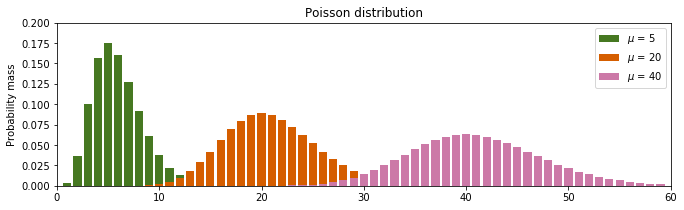

In [2]:
fig = plt.figure(figsize=(11,3))
x_lim = 60
mu = [5, 20, 40]
x = np.arange(x_lim)
plt.bar(x, stats.poisson.pmf(mu[0], x), color=colors[3])
plt.bar(x, stats.poisson.pmf(mu[1], x), color=colors[4])
plt.bar(x, stats.poisson.pmf(mu[2], x), color=colors[5])
    
plt.xlim(0, x_lim), plt.ylim(0, 0.2)
plt.ylabel('Probability mass')
plt.title('Poisson distribution')
plt.legend(['$\mu$ = %s' % mu[0], '$\mu$ = %s' % mu[1], '$\mu$ = %s' % mu[2]])
plt.show()

Рассмотрим, как выглядит гистограмма распределения количества сообщений в зависимости от времени задержки:

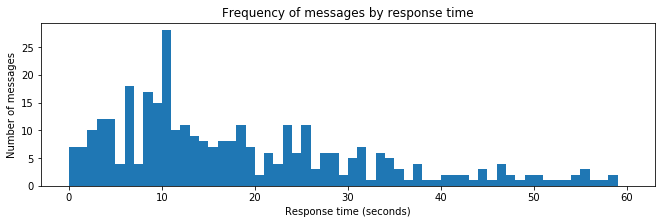

In [3]:
fig = plt.figure(figsize=(11,3))
plt.hist(messages['time_delay_seconds'].values, 
         range=[0, 60], bins=60, histtype='stepfilled')

plt.title('Frequency of messages by response time')
plt.xlabel('Response time (seconds)')
plt.ylabel('Number of messages')
plt.show()

### Точечная оценка параметра $\mu$

Составим функцию правдоподобия и найдем, при каком $\mu$ достигается ее максимум:

In [4]:
y_obs = messages['time_delay_seconds'].values

def log_likelihood(mu, y_obs, sign=-1):
    if mu <= 0:
        return -sign * np.inf
    return  sign * np.sum(stats.poisson.logpmf(y_obs, mu=mu))

In [5]:
freq_results = opt.minimize_scalar(log_likelihood, args=[y_obs])
print("The estimated value of mu is: %s" % freq_results['x'])

The estimated value of mu is: 18.2307692324


c:\anaconda2\envs\py36\lib\site-packages\scipy\optimize\optimize.py:2189: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


На картинке ниже показана функция правдоподобия, для которой ищется точка максимума:

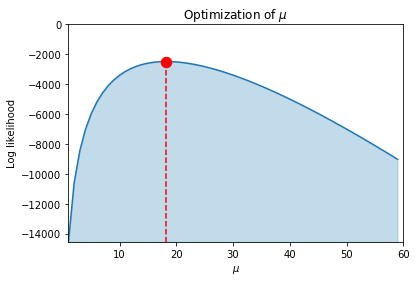

In [6]:
mu = np.arange(1, 60)
llike = np.array([log_likelihood(i, y_obs, sign=1) for i in mu])

y_min, y_max = np.min(llike), np.max(llike)
fig = plt.figure(figsize=(6,4))
plt.plot(mu, llike)
plt.fill_between(mu, llike, y_min, color=colors[0], alpha=0.3)
plt.title('Optimization of $\mu$')
plt.xlabel('$\mu$'), plt.ylabel('Log likelihood')
plt.vlines(freq_results['x'], y_max, y_min, colors='red', linestyles='dashed')
plt.scatter(freq_results['x'], y_max, s=110, c='red', zorder=3)
plt.ylim(y_min, 0), plt.xlim(1, 60)
plt.show()

Оценка для $\mu$ оказалась равной 18.23. Но хотелось бы наравне с точечной оценкой увидеть величину ее разброса. Пока непонятно, как ее получить.

Вернемся к найденному значению $\mu$ и посмотрим, как при таком параметре выглядит распределение времени задержки в отправке сообщений:

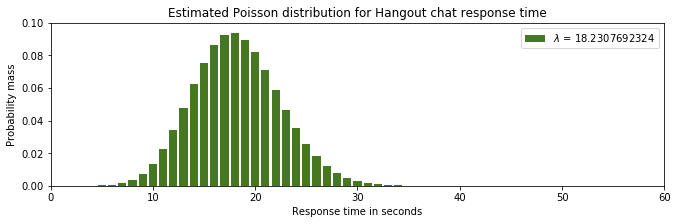

In [7]:
fig = plt.figure(figsize=(11,3))
x = np.arange(60)
mu = freq_results['x']
plt.bar(x, stats.poisson.pmf(x, mu=mu), color=colors[3])
    
plt.xlim(0, x_lim), plt.ylim(0, 0.1)
plt.xlabel('Response time in seconds')
plt.ylabel('Probability mass')
plt.title('Estimated Poisson distribution for Hangout chat response time')
plt.legend(['$\lambda$ = %s' % mu])
plt.show()

Как видно из графика распределения, для найденного $\mu$ вероятность задержки менее 10 секунд или более 30 секунд крайне мала. Однако это не вполне согласуется с эмпирическим распределением, в котором всречаются значения от 0 до 60. Возможно, стоит пересмотреть модель. Мы сделаем это чуть позже, а сейчас рассмотрим еще один способ оценки параметра.

### Байесовских подход к оценке $\mu$
 
В основе подхода лежит теорема Байеса:
$$\overbrace{p(\mu \ |\ Data)}^{\text{posterior}} = \dfrac{\overbrace{p(Data \ | \ \mu)}^{\text{likelihood}} \cdot \overbrace{p(\mu)}^{\text{prior}}}{\underbrace{p(Data)}_{\text{marginal likelihood}}}$$

В условиях нашей задачи мы задаем априорное распределение (prior) для $\mu$, полагая его равномерным на \[0, 60\] (других предпосылок у нас нет). Наблюдаемые величины порождаются из распределения Пуассона, единственным параметром которого является параметр $\mu$:

<img src="https://github.com/markdregan/Bayesian-Modelling-in-Python/blob/master/graphics/Poisson-dag.png?raw=true" width="320" height="200" />

### Генерация выборки из апостериорного распределения методом MCMC
Вместо точечной оценки параметра $\mu$ (как в частотном подходе), будем оценивать правдоподобие  $\mu$ при условии данной выборки наблюдений. Оценивать распределение можно двумя способами:
* перебирать всевозможные  $\mu$ и вычислять правую часть формулы Байеса
* сэмплить выборку из левой части формулы Байеса.

Первый путь заведомо приведет к существенным вычислительным трудностям, когда перебор будет проходить в пространствах с большой размерностью. Поэтому обратимся ко второму, и здесь пригодится MCMC. Напомним, что в этом методе достаточно задать желаемое распределение с точностью до нормировки, а это ровно то, что мы легко можем сделать:

$$\overbrace{p(\mu \ |\ Data)}^{posterior} \varpropto \overbrace{p(Data \ | \ \mu)}^{likelihood} \cdot \overbrace{p(\mu)}^{prior}$$

Счастливым образом отпала необходимость вычислять полную вероятность $p(Data)$, которую, впрочем, мы и не умеем вычислять.

Анимация на картинке ниже показывает, как происходит оценка апостериорного распределения в задаче с двумя параметрами. Для оценки запускается 3 реализации цепи Маркова со случайной инициализацией. 

Заметим, что в отличие от точечного оценивания, мы не стремимся кратчайшим путем прийти к точке, в которой максимизируется апостериорная вероятность, а неким "умным" способом обходим пространство и восстанавливаем **само распределение**.

![](https://github.com/markdregan/Bayesian-Modelling-in-Python/blob/master/graphics/mcmc-animate.gif?raw=true)

Задаем априорное распределение и указываем способ вычисления апостериорного:

In [8]:
def log_prior(theta):
    if theta <= 0 or theta >= 60:
        return -np.inf
    else:
        return np.log(1./60)

def log_posterior(theta, y_obs):
    return log_prior(theta) + log_likelihood(theta, y_obs, sign=1)

Метод МСМС реализуем с помощью библиотеки ```emcee```:

In [9]:
import emcee

ndim, nwalkers = 1, 50
nsteps = 1000

starting_guesses = np.random.rand(nwalkers, ndim) * 60

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[y_obs])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain

Одна из реализиций:

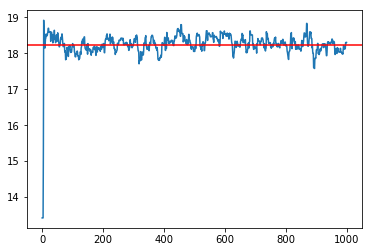

In [16]:
plt.plot(sample[18])
plt.axhline(freq_results['x'], c='r')
plt.show()

Распределение параметра $\mu$ на основе выборки, генерируемой методом МСМС:

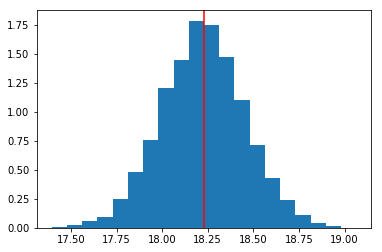

In [11]:
burnin = 400
plt.hist(sample[:, burnin:].ravel(), normed=True, bins=20)
plt.axvline(freq_results['x'], c='r')
plt.show()

Обратим внимание, что автокорреляционная функция достаточно быстро убывает, что хорошо:

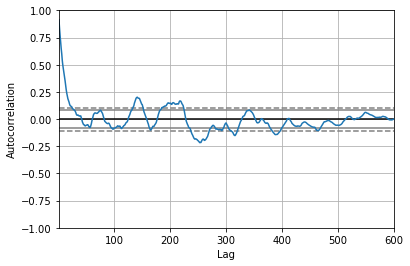

In [12]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(sample[15].ravel()[burnin:])
plt.show()

### Новая модель данных

Есть предположение, что эмпирическое распределеине больше походит на отрицательное биномиальное распределение. Реализуйте методом МСМС оценку параметров в модели с отрицательным биномиальным распределением. Сравните выборку из распределения с найденными параметрами и эмпирическое распределение.

<img src="https://github.com/markdregan/Bayesian-Modelling-in-Python/blob/master/graphics/Neg%20Binomial%20Dag.png?raw=true" width="400" height="200" />

### Выбор более подходящего распределения

Теперь у нас есть две подели: на основе распределения Пуассона и отрицательного биномиального. Какое из них выбрать? Вновь воспользуемся байесовским подходом. Пусть $\tau$ принимает значения 0 и 1, где 0 означает, что данные моделируются распределением Пуассона, а 1 - отрицательным биномиальным. Априори про распределение $\tau$ можем лишь предположить, что значения 0 и 1 равновероятны. Методом МСМС оцените апостериорное распределение $\tau$, вычислите байесовский фактор и примите решение в пользу первой или второй модели.

<img src="https://github.com/markdregan/Bayesian-Modelling-in-Python/blob/master/graphics/Bayes%20Factor%20DAG.png?raw=true" width="540" height="200" />

Определение байесовского фактора:

$$\frac{P(Data \ | \ M_{1})}{P(Data \ | \ M_{2})} = B.F. \times \frac{P(M_{1})}{P(M_{2})}$$